In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install google-play-scraper
!pip install umap-learn

In [ ]:
import string
import re
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import umap
from google_play_scraper import Sort, reviews
warnings.filterwarnings('ignore')
sns.set(style='white', palette='muted', color_codes=True)

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
result, continuation = reviews(
    'com.Info_BMKG',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=1000,
    filter_score_with=None
)

In [ ]:
df = pd.DataFrame(np.array(result), columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,27a862bd-d73e-4e2e-898d-eb1377494125,KY Art,https://play-lh.googleusercontent.com/a/ACg8oc...,Ada baiknya di tambahkan alarm EWS pada aplika...,3,113,3.3.1,2024-08-13 16:07:59,None,NaT,3.3.1
1,d12f7c25-80f7-415c-b4c7-4c4ec77ad7d9,Youdi Steve,https://play-lh.googleusercontent.com/a/ACg8oc...,Sampaikan ke BMKG utk meletakkan ribuan alarm ...,1,14,3.3.1,2024-08-24 23:21:11,None,NaT,3.3.1
2,54e783f9-9f3d-4c44-bb25-bdb8b597993a,Robert Anthony,https://play-lh.googleusercontent.com/a/ACg8oc...,tidak ada widget update cuaca 24 jam! kalah sa...,1,5,3.3.1,2024-09-11 01:12:48,None,NaT,3.3.1
3,a4d14155-a766-4a35-b842-ae35120ca7ef,Gary Christian,https://play-lh.googleusercontent.com/a-/ALV-U...,Tampilan informasi sudah cukup bagus. Saran : ...,5,70,3.3.1,2024-08-23 00:13:40,None,NaT,3.3.1
4,5974970c-60f8-439c-a531-1c5146da790f,Bismi m. Amanu,https://play-lh.googleusercontent.com/a-/ALV-U...,"bgus aplikasi nya, semoga bisa diandalkan kaya...",5,5,3.3.1,2024-09-17 06:41:34,None,NaT,3.3.1


In [ ]:
df.shape

(1000, 11)

In [ ]:
df = df.iloc[:, 3:5]
df.head()

,content,score
0,Ada baiknya di tambahkan alarm EWS pada aplika...,3
1,Sampaikan ke BMKG utk meletakkan ribuan alarm ...,1
2,tidak ada widget update cuaca 24 jam! kalah sa...,1
3,Tampilan informasi sudah cukup bagus. Saran : ...,5
4,"bgus aplikasi nya, semoga bisa diandalkan kaya...",5


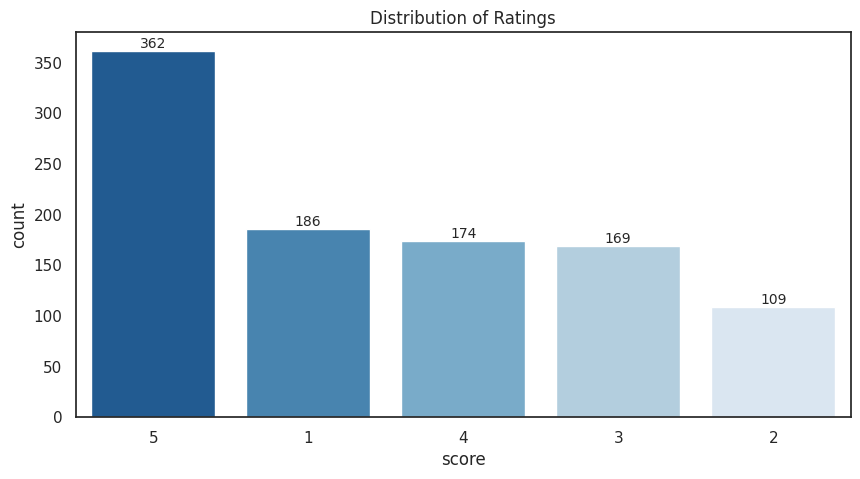

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='score', data=df, order=df.score.value_counts().index, palette='Blues_r')
for container in ax.containers:
    ax.bar_label(container, label_type='edge', size=10)
plt.title('Distribution of Ratings')
plt.show()

In [ ]:
def sentiment(score):
  if score <= 2:
    return 'Negative'
  elif score >= 4:
    return 'Positive'

df['score'] = df['score'].apply(lambda x: sentiment(x))

In [ ]:
df.score.value_counts()

,count
score,
Positive,536
Negative,295


In [ ]:
df.isnull().sum()

,0
content,0
score,169


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(831, 2)

## Data Preprocessing

In [ ]:
# casefolding
def casefolding(content):
  content = content.lower()
  return content

df['content'] = df['content'].apply(lambda x: casefolding(x))

In [ ]:
# cleaning
def cleaning(content):
  content = content.strip(' ')
  content = re.sub(r'\d+', '', content)
  content = content.translate(str.maketrans('','', string.punctuation))
  content = re.sub(r'\b[a-zA-Z]\b', '', content)
  content = re.sub(r'\s+', ' ', content)
  return content

df['content'] = df['content'].apply(lambda x: cleaning(x))

In [ ]:
# emoji removal
def emoji_removal(content):
  content = emoji.replace_emoji(content, replace='')
  return content

df['content'] = df['content'].apply(lambda x: emoji_removal(x))

In [ ]:
# emoticon removal
def remove_emoticons(content):
    emoticon_pattern = re.compile(r"""
        (?::|;|=)
        (?:-)?
        (?:\)|\(|D|P|O|/|\\|S)
        """, re.VERBOSE)

    return emoticon_pattern.sub(r'', content)

df['content'] = df['content'].apply(lambda x: remove_emoticons(x))

In [ ]:
# norm
norm = {
    'gak': 'tidak',
    'bgt': 'banget',
    'yg': 'yang',
    'tp': 'tapi',
    'gimana': 'bagaimana',
    'aku': 'saya',
    'udh': 'udah',
    'gue': 'saya',
    'emang': 'memang',
    'mau': 'ingin',
    'abis': 'habis',
    'bener': 'benar',
    'nggak': 'tidak',
    'aja': 'saja',
    'gitu': 'begitu',
    'kalo': 'kalau',
    'udah': 'sudah',
    'cuma': 'hanya',
    'tuh': 'itu',
    'utk': 'untuk',
    'dr': 'dari',
    'sy': 'saya',
    'bgus': 'bagus',
    'ucpan': 'ucapan',
    'ssudah': 'sudah'
}

def normalize(content):
  for i in norm:
    if i in content:
      content = content.replace(i, norm[i])
  return content

df['content'] = df['content'].apply(lambda x: normalize(x))

In [ ]:
# stopword
factory = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(factory)
stopword = StopWordRemover(new_array)

def stopwords(content):
  content = stopword.remove(content)
  return content

df['content'] = df['content'].apply(lambda x: stopwords(x))

In [ ]:
# tokenisasi
def tokenisasi(content):
  content = word_tokenize(content)
  return content

df['content'] = df['content'].apply(lambda x: tokenisasi(x))

In [ ]:
# stemming
def stemming(content):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  text = []
  for i in content:
    x = stemmer.stem(i)
    text.append(x)
  content_clean = []
  content_clean = ' '.join(text)
  print(content_clean)
  return content_clean

df['content'] = df['content'].apply(lambda x: stemming(x))

df.to_csv('bmkg_clean_data.csv')

sampai bmkg letak ribu alarm gempa bagi sumur milik instansi warga buat ribu sumur sendiri dgn dalam ribu meter dekat dgn akses wifi dekat dgn kabel optik akses internet hubung aplikasi lalu semua hape wajib aplikasi sehinggga jadi gempa alarm central over the top aplikasi akan bunyi keras ingat semua orang tinggal km lokasi gempa
ada widget update cuaca jam kalah sama aplikasi jenis harus bmkg ada widget cuaca jam kita perlu masuk aplikasi ingin update cuaca
tampil informasi cukup bagus saran bagi dashboard buat user save beberapa lokasi prakira cuaca dapat tampil sama terimakasih
bagus aplikasi nya moga andal kayak aplikasi ingat dini jepang yang kasih masuk tambah live chat di aplikasi komentar tuju sih
asalamualaikum kak alhamdulillah semenjak aplikasi kita lihat cuaca titik gempa kurang kalaw tambah kan komentar live nya biar ada yang kabarin kalaw jadi apa apa cuaca atau lingkung dan juga komentar langsung cuaca daerah begitu
aplikasi nya sangat bantu sekalidan baik sekali moga d

In [ ]:
path = '/content/bmkg_clean_data.csv'

df_clean = pd.read_csv(path)
df_clean.drop('Unnamed: 0', axis=1, inplace=True)
df_clean.head()

,content,score
0,sampai bmkg letak ribu alarm gempa bagi sumur ...,Negative
1,ada widget update cuaca jam kalah sama aplikas...,Negative
2,tampil informasi cukup bagus saran bagi dashbo...,Positive
3,bagus aplikasi nya moga andal kayak aplikasi i...,Positive
4,asalamualaikum kak alhamdulillah semenjak apli...,Positive


In [ ]:
df_clean.rename(columns={'content': 'text', 'score': 'sentiment'}, inplace=True)

In [ ]:
df_clean['sentiment'] = df_clean['sentiment'].map({'Negative': 0, 'Positive': 1})
df_clean.head()

,text,sentiment
0,sampai bmkg letak ribu alarm gempa bagi sumur ...,0
1,ada widget update cuaca jam kalah sama aplikas...,0
2,tampil informasi cukup bagus saran bagi dashbo...,1
3,bagus aplikasi nya moga andal kayak aplikasi i...,1
4,asalamualaikum kak alhamdulillah semenjak apli...,1


## Text Visualization

In [ ]:
# word cloud
sen_positive = df_clean[df_clean['sentiment'] == 1]
sen_negative = df_clean[df_clean['sentiment'] == 0]

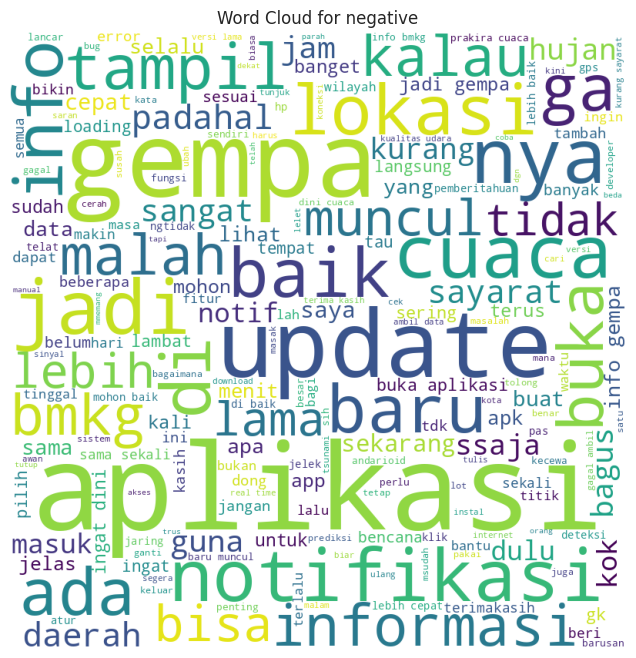

In [ ]:
text_negative = ' '.join(sen_negative['text'])
text_positive = ' '.join(sen_positive['text'])

wordcloud_negative = WordCloud(width = 800, height = 800,
                background_color ='white',
                mode = 'RGBA',
                min_font_size = 10).generate(text_negative)

plt.figure(figsize = (8, 8))
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.title('Word Cloud for negative')
plt.show()

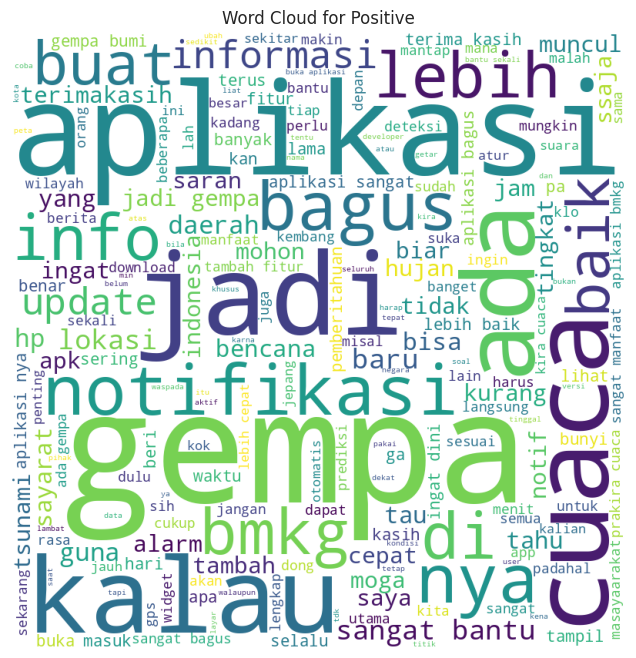

In [ ]:
wordcloud_positive = WordCloud(width = 800, height = 800,
                background_color ='white',
                mode = 'RGBA',
                min_font_size = 10).generate(text_positive)

plt.figure(figsize = (8, 8))
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.title('Word Cloud for Positive')
plt.show()

In [ ]:
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df_clean['text'])
X_tfidf

<831x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 13139 stored elements in Compressed Sparse Row format>

In [ ]:
X_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.26403338, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_tfidf.toarray())

df_clean['umap_1'] = X_umap[:, 0]
df_clean['umap_2'] = X_umap[:, 1]

In [ ]:
df_clean

,text,sentiment,umap_1,umap_2
0,sampai bmkg letak ribu alarm gempa bagi sumur ...,0,12.069129,-0.797879
1,ada widget update cuaca jam kalah sama aplikas...,0,13.447398,2.941408
2,tampil informasi cukup bagus saran bagi dashbo...,1,11.820051,1.041953
3,bagus aplikasi nya moga andal kayak aplikasi i...,1,12.802735,-1.210087
4,asalamualaikum kak alhamdulillah semenjak apli...,1,12.746858,-1.125472
...,...,...,...,...
826,enak versi lama cuaca maritim pantau buat bebe...,1,10.172952,1.629513
827,barusan asa banget gempa cianjur knpa ga sayar...,0,12.242755,1.764186
828,mohon sekira beri ingat atas parakiran cuaca b...,1,12.787638,0.277851
829,aplikasi kadangkadang saja kurang sayarat lebi...,0,13.669578,1.362694


In [ ]:
df_clean.sentiment.value_counts().T

,count
sentiment,
1,536
0,295


In [ ]:
fig = px.scatter(df_clean, x='umap_1', y='umap_2', color='sentiment', title='UMAP Visualization of BMKG App Reviews', text='text')
fig.update_layout(height=650)
fig.show()



---

